--- Início do Script de Treinamento de Modelo de Fraude ---
Dataset 'creditcard.csv' carregado com sucesso.

--- Verificando e Removendo Linhas com NaN na Coluna 'Class' ---
Foi removida 1 linha problemática. Índice da linha: 17917

O dataset possui 17917 linhas e 31 colunas.
Verificando a distribuição das classes (0: Legítima, 1: Fraude):
Class
0.0    17836
1.0       81
Name: count, dtype: int64
Porcentagem de transações fraudulentas: 0.4521%
Esta é a confirmação de um dataset extremamente desbalanceado.

--- Iniciando o Pré-processamento ---
Dados divididos em conjuntos de treino (80%) e teste (20%).

--- Tratando o Desbalanceamento de Classes com SMOTE ---
Distribuição original no treino: 
Class
0.0    14268
1.0       65
Name: count, dtype: int64
Distribuição após SMOTE no treino: 
Class
0.0    14268
1.0    14268
Name: count, dtype: int64

--- Treinando o Modelo RandomForestClassifier ---
Modelo treinado com sucesso.

--- Avaliando o Desempenho do Modelo no Conjunto de Teste ---

Re

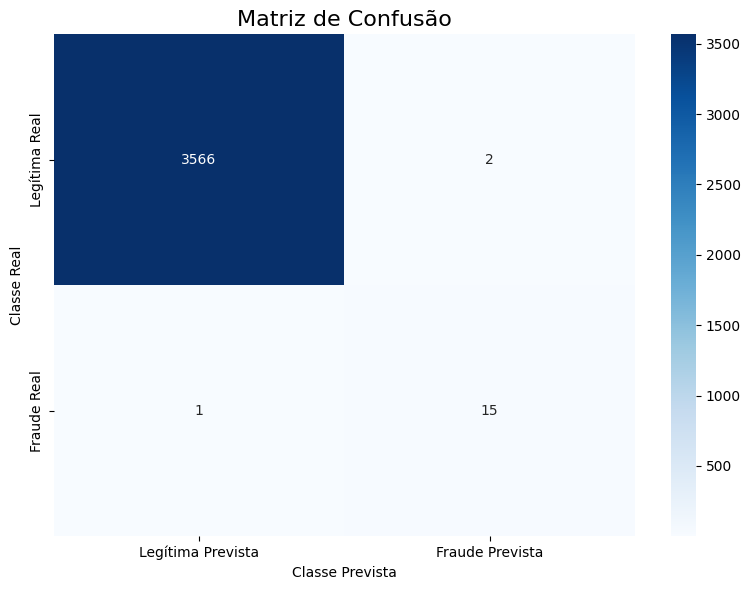

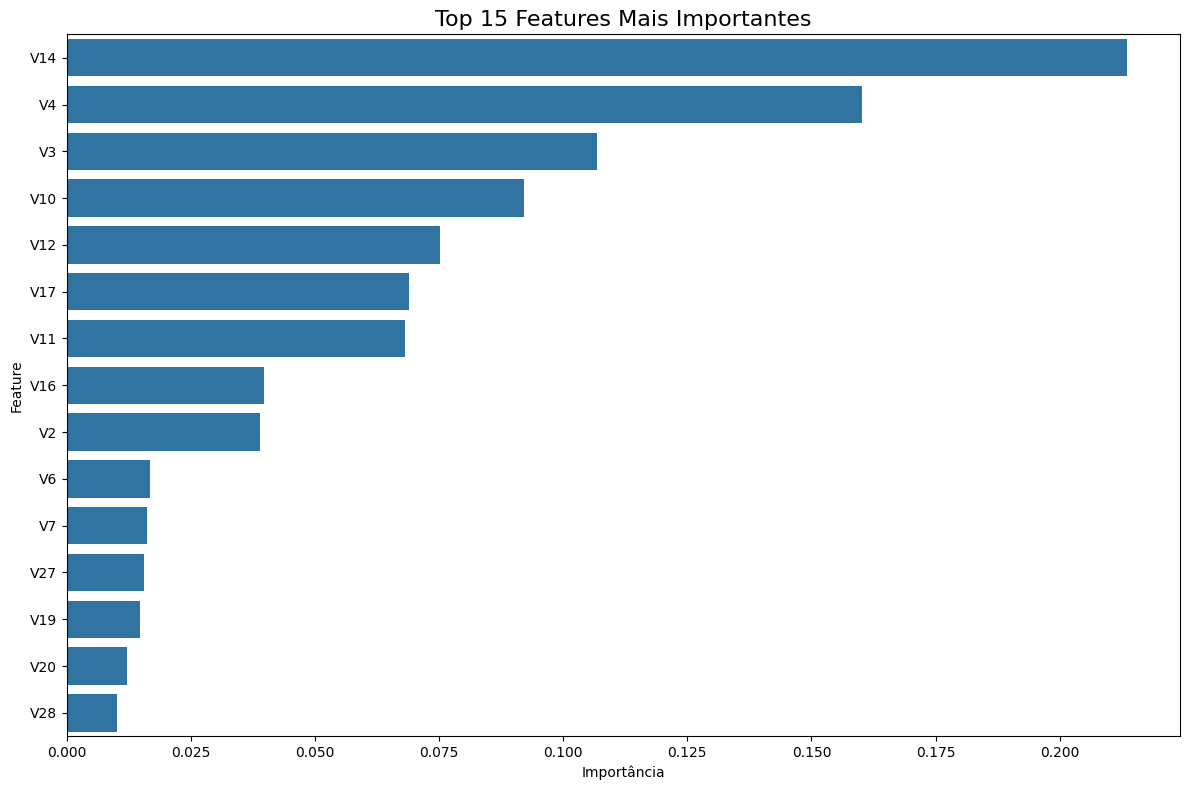

In [ ]:
# -*- coding: utf-8 -*-
"""
Script Completo para Treinamento de Modelo de Detecção de Fraude

Este script realiza o ciclo completo de um projeto de Machine Learning padrão:
1. Carregamento e Análise Exploratória dos Dados (EDA).
2. Pré-processamento dos dados (normalização).
3. Divisão em conjuntos de treino и teste de forma estratificada.
4. Tratamento do desbalanceamento de classes com a técnica SMOTE.
5. Treinamento de um modelo de classificação (Random Forest).
6. Avaliação detalhada do modelo com métricas apropriadas (Recall, Precision, Matriz de Confusão).
7. Visualização dos resultados para melhor interpretação.
8. Salvamento do modelo treinado e do normalizador para uso futuro (produção).

Autor: [Seu Nome Aqui]
Data: 19 de agosto de 2025

Fonte do Dataset: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
"""

# =============================================================================
# 1. IMPORTAÇÃO DAS BIBLIOTECAS
# =============================================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

print("--- Início do Script de Treinamento de Modelo de Fraude ---")

# =============================================================================
# 2. CARREGAMENTO E LIMPEZA DOS DADOS
# =============================================================================
try:
    df = pd.read_csv('creditcard.csv')
    print("Dataset 'creditcard.csv' carregado com sucesso.")
except FileNotFoundError:
    print("Erro: O arquivo 'creditcard.csv' não foi encontrado.")
    print("Por favor, baixe o dataset e coloque-o na mesma pasta do script.")
    exit()

print("\n--- Verificando e Removendo Linhas com NaN na Coluna 'Class' ---")

# 1. Identifica os índices das linhas com NaN na coluna 'Class' ANTES de remover
indices_para_remover = df[df['Class'].isnull()].index

# 2. Verifica se de fato há alguma linha para remover
if not indices_para_remover.empty:
    linhas_antes = len(df)

    # Converte o objeto de índice para uma lista para uma exibição mais clara
    lista_indices = list(indices_para_remover)

    # 3. Remove as linhas problemáticas
    df.dropna(subset=['Class'], inplace=True)
    linhas_depois = len(df)

    # 4. Imprime uma mensagem detalhada, mostrando os índices
    num_removidas = linhas_antes - linhas_depois
    if num_removidas == 1:
        # Mensagem para o caso de remover apenas uma linha
        print(f"Foi removida {num_removidas} linha problemática. Índice da linha: {lista_indices[0]}")
    else:
        # Mensagem para o caso de remover múltiplas linhas
        print(f"Foram removidas {num_removidas} linhas problemáticas. Índices das linhas: {lista_indices}")
else:
    print("Nenhuma linha com NaN na coluna 'Class' encontrada. Nenhuma linha foi removida.")

# =============================================================================
# 3. ANÁLISE EXPLORATÓRIA RÁPIDA (EDA)
# =============================================================================
print(f"\nO dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.")
print("Verificando a distribuição das classes (0: Legítima, 1: Fraude):")
class_counts = df['Class'].value_counts()
print(class_counts)
fraud_percentage = (class_counts[1] / class_counts.sum()) * 100
print(f"Porcentagem de transações fraudulentas: {fraud_percentage:.4f}%")
print("Esta é a confirmação de um dataset extremamente desbalanceado.")

# =============================================================================
# 4. PRÉ-PROCESSAMENTO DOS DADOS
# =============================================================================
print("\n--- Iniciando o Pré-processamento ---")

# Criando uma cópia para evitar warnings
df_proc = df.copy()

# Normalizando as colunas 'Amount' e 'Time', que possuem escalas muito diferentes das colunas V
scaler = StandardScaler()
df_proc['scaled_amount'] = scaler.fit_transform(df_proc['Amount'].values.reshape(-1, 1))
df_proc['scaled_time'] = scaler.fit_transform(df_proc['Time'].values.reshape(-1, 1))

# Removendo as colunas originais
df_proc.drop(['Time', 'Amount'], axis=1, inplace=True)

# Separando features (X) e o alvo (y)
X = df_proc.drop('Class', axis=1)
y = df_proc['Class']

# Divisão em conjuntos de treino e teste
# O parâmetro 'stratify=y' é ESSENCIAL para manter a proporção de classes nos dois conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Dados divididos em conjuntos de treino (80%) e teste (20%).")

# =============================================================================
# 5. TRATAMENTO DO DESBALANCEAMENTO COM SMOTE
# =============================================================================
print("\n--- Tratando o Desbalanceamento de Classes com SMOTE ---")
print(f"Distribuição original no treino: \n{y_train.value_counts()}")

smote = SMOTE(random_state=42)
# IMPORTANTE: O SMOTE é aplicado APENAS nos dados de TREINO para evitar vazamento de dados (data leakage)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Distribuição após SMOTE no treino: \n{y_train_resampled.value_counts()}")

# =============================================================================
# 6. TREINAMENTO DO MODELO
# =============================================================================
print("\n--- Treinando o Modelo RandomForestClassifier ---")
# RandomForest é um modelo robusto e bom para dados tabulares
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=10, n_estimators=100)

# O modelo é treinado com os dados de treino balanceados
rf_model.fit(X_train_resampled, y_train_resampled)
print("Modelo treinado com sucesso.")

# =============================================================================
# 7. PREVISÃO E AVALIAÇÃO
# =============================================================================
print("\n--- Avaliando o Desempenho do Modelo no Conjunto de Teste ---")
# As previsões são feitas no conjunto de teste original (desbalanceado), que simula a realidade
y_pred = rf_model.predict(X_test)

print("\nRelatório de Classificação:")
# O classification_report mostra as principais métricas de classificação
# Foco especial em 'recall' para a classe 1 (Fraude)
print(classification_report(y_test, y_pred, target_names=['Legítima (0)', 'Fraude (1)']))

print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred):.4f}")

# Gerando a Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

# =============================================================================
# 8. VISUALIZAÇÃO DOS RESULTADOS
# =============================================================================
print("\n--- Gerando Visualizações ---")

# Criar a pasta 'reports' se ela não existir
output_dir = 'reports'
os.makedirs(output_dir, exist_ok=True)

# Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legítima Prevista', 'Fraude Prevista'],
            yticklabels=['Legítima Real', 'Fraude Real'])
plt.title('Matriz de Confusão', fontsize=16)
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'matriz_confusao.png'))
print(f"Gráfico 'matriz_confusao.png' salvo na pasta '{output_dir}'.")
# plt.show() # Descomente para exibir o gráfico diretamente

# Importância das Features
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 15 Features Mais Importantes', fontsize=16)
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'importancia_features.png'))
print(f"Gráfico 'importancia_features.png' salvo na pasta '{output_dir}'.")
# plt.show() # Descomente para exibir o gráfico diretamente

# =============================================================================
# 9. SALVANDO O MODELO PARA PRODUÇÃO
# =============================================================================
print("\n--- Salvando o Modelo e o Normalizador ---")

# Salva o modelo treinado em um arquivo
joblib.dump(rf_model, 'fraud_model.pkl')
print("Modelo salvo como 'fraud_model.pkl'")

# Salva o objeto scaler, essencial para processar novos dados da mesma forma que os dados de treino
joblib.dump(scaler, 'scaler.pkl')
print("Normalizador salvo como 'scaler.pkl'")

print("\n--- Fim do Script ---")